# Assessment 2 
During the covid pandemic, governments tried to predict the levels of infection so that they could manage the required infrastructure, especially hospital beds and (sadly) mortuary places. In this mini-project, you will take data from two different, publicly available, sources and try to see how well you could have done if you had been working for the UK government.  One of the sources is the UK data from the period and the other is google’s data on our behaviour during the pandemic.

You will use data up to a specific date to predict hospital beds needed, and deaths that will occur  in one, two, three and four weeks from that date.  You will do this for the whole pandemic period i.e. using a rolling  window. You will also quantify how well your prediction works.

Things that you might want to consider in your analysis include:

- There will be a time lag between people’s  behaviour changing and the number of people requiring a hospital bed (and another between people requiring hospitalisation and them dying).

- Both sources of data will have information that is  of no use to you and you will have to investigate those sources that are useful to you. You should start by thinking this through and then trying the effect of different variable.

- Both data sets may require some cleaning and (perhaps) some smoothing to remove effects such as weekends etc.

- As the situation changed some aspects of the older data nay or may not continue to be useful.  

- You may wish to do this by region or for the whole country, or even to compare the two.

We will provide you with basic code to access the data. It is up to you if you use it or not.


## 1. Setup

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

import matplotlib.pylab as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
#Show plots inline
%matplotlib inline

#Some date formatters to use for plotting 
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')

In [2]:
#seaborn is a useful package for handling graphics and 
#producing publication quality images with better colour schemes
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_context("talk")
#sns.set(font_scale=1.5) 
#sns.set_context("poster")

plt.rcParams.update({'font.size': 32})
plt.rcParams.update({'lines.linewidth':3})

## 2. Predictors

In principle, covid cases, hospital admissions, and deaths are time-lagged outcomes of covariates or "predictor variables" such as the level of interactions in the population, mobility metrics, levels of restrictions etc.

A data set which is often used as a possible predictor is google mobility metrics https://www.google.com/covid19/mobility/.

In [3]:
#Import the data from Google.
#This is a large file!
df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')

/tmp/ipykernel_7793/1332668652.py:3: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_google = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv')


In [4]:
#Select `United Kingdom` from the full data.
df_google = df_google[df_google['country_region']=='United Kingdom']
#Discard sub regions
#Note - we England vs UK
df_google = df_google[df_google['sub_region_1'].isnull()]

In [5]:
#Re-index by data
df_google.set_index(pd.to_datetime(df_google['date']),inplace=True)
df_google.sort_index(inplace=True)
df_google.columns

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')

Plot up some of the metrics. 

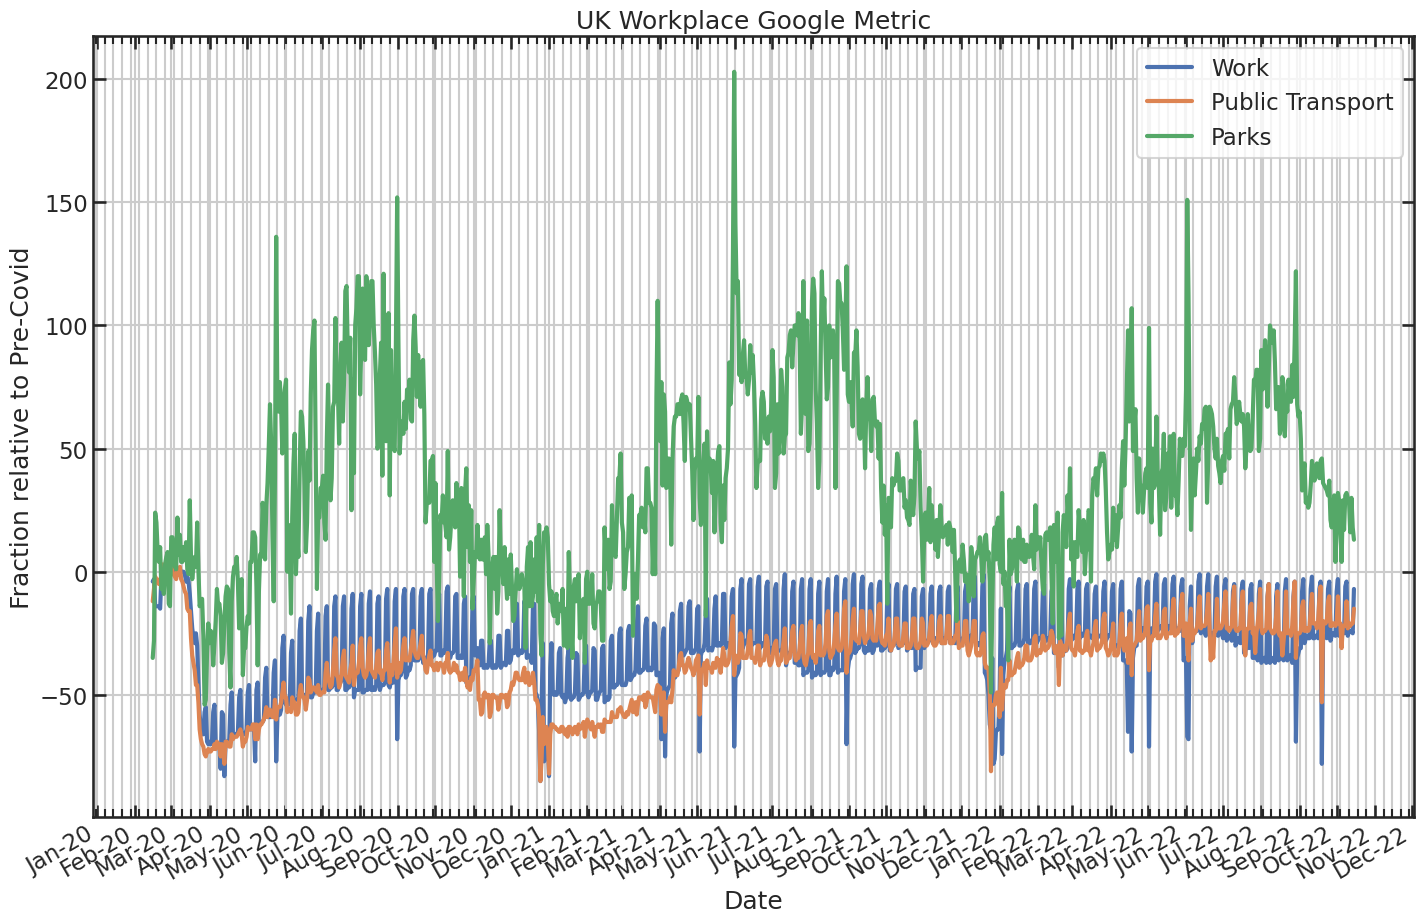

In [6]:
fig, ax = plt.subplots(figsize=(15,10),sharex= True, facecolor='white')

ax.plot(df_google.index,df_google['workplaces_percent_change_from_baseline'],label='Work')
ax.plot(df_google.index,df_google['transit_stations_percent_change_from_baseline'],label='Public Transport')
ax.plot(df_google.index,df_google['parks_percent_change_from_baseline'],label='Parks')


ax.tick_params(axis="both", direction="in", which="both", right=True,left=True, top=True, bottom=True)


ax.grid(which='both')
ax.set_xlabel('Date')
ax.set_ylabel('Fraction relative to Pre-Covid')

# format the ticks
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)
#ax.set_xlim(left=dt.datetime(2021,7,1))
ax.set_title('UK Workplace Google Metric')
ax.legend()

_= fig.autofmt_xdate()

plt.tight_layout()
plt.savefig('mobility.png')

## The UK data from the covid period.

The UK data is available as a zip file from:

https://ukhsa-dashboard.data.gov.uk/covid-19-archive-data-download

this then needs to be unzipped 
```console
unzip  covid-19-archive.zip
```
This should produce a series of directories:
```console
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Cases
-rw-r--r--. 1 collngdj collngdj 1592889236 Oct 25 16:07 covid-19-archive.zip
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Deaths
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Healthcare
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Testing
drwxr-xr-x. 1 collngdj collngdj        126 Oct 25 16:08 Vaccinations
```

each of these has a set of csv files arranged over different years.

The following code is an example of how you might want to read these in and concatinate them over different years.



In [7]:
import re
from enum import StrEnum, auto
import pathlib
import pandas as pd

class DataType(StrEnum):
    Cases = auto()
    Deaths = auto()
    Healthcare = auto()
    Testing = auto()
    Vaccinations = auto()


def csvconcat(datatype: DataType,
              metric: str | None = None,
              dataroot: str | pathlib.Path = pathlib.Path.cwd()) -> dict[str, pd.DataFrame]:
    """
    Get Pandas DataFrames from the UK COVID-19 .csv data, Concatenated across years.

    Args:
        datatype (DataType): Corresponds to the directory to scan use enum type above.
                             i.e. [DataType.Cases|DataType.Deaths|DataType.Healthcare|
                                   DataType.Testing|DataType.Vaccinations]
        metric (str | None, optional): Chose an individual metric to process. If None (the default) then all
                                       metrics for the given DataType are processed. Defaults to None.
        dataroot (pathlib.Path, optional): The root directory for the unpacked UK COVID-19 data.
                                           DataType directories (Cases/Deaths) etc should be under this root.
                                           Defaults to pathlib.Path.cwd().
    Raises:
        ValueError: If there is a failure to convert the given dataroot to a Path object.

    Returns:
        dict[str, pd.DataFrame]: The mapping from metric to fully concatenated DataFrame.
    """
    if not isinstance(dataroot, pathlib.Path):
        try:
            dataroot = pathlib.Path(dataroot)
        except:
            raise ValueError(f"dataroot: '{dataroot}' could not be converted to a Path.")

    dataroot /= datatype.name
    # metric_regex = re.compile(r"(?P<metric>\w+?)_(?P<specifier>nation|region|utla|ltla|overview)_20\d\d.csv")
    metric_regex = re.compile(r"(?P<specifier>nation|region|nhsRegion|nhsTrust|utla|ltla|msoa|overview)_(?P<metric>\w+?).csv")
    metrics: set[str] = {str(metric)}
    if metric is None:
        file_list = (file_.relative_to(dataroot).name for file_ in dataroot.rglob("*.csv"))
        metrics = {match.group("metric") for file_ in file_list if (match := metric_regex.match(file_))}

    ret = {}
    for current_metric in metrics:
        ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"*_{current_metric}.csv"))})
        # ret.update({current_metric: pd.concat(pd.read_csv(file_) for file_ in dataroot.rglob(f"{current_metric}_*.csv"))})

    return ret



In [8]:
# Get a specific metric
data = csvconcat(DataType.Healthcare, "hospitalCases", r"/home/ks2922/Applied Machine Learning/Assessments/Assessment 2/covid-19-archive")
print(data)

{'hospitalCases':             date area_type  area_code        area_name         metric  \
0     2020-03-27  overview  K02000001   United Kingdom  hospitalCases   
1     2020-03-28  overview  K02000001   United Kingdom  hospitalCases   
2     2020-03-29  overview  K02000001   United Kingdom  hospitalCases   
3     2020-03-30  overview  K02000001   United Kingdom  hospitalCases   
4     2020-03-31  overview  K02000001   United Kingdom  hospitalCases   
...          ...       ...        ...              ...            ...   
3235  2020-12-27    region  E12000008       South East  hospitalCases   
3236  2020-12-27    region  E12000006  East of England  hospitalCases   
3237  2020-12-27    region  E12000001       North East  hospitalCases   
3238  2020-12-27    region  E12000005    West Midlands  hospitalCases   
3239  2020-12-27    region  E12000009       South West  hospitalCases   

               metric_name    value  
0     Patients in hospital   7267.0  
1     Patients in hospital   

In [9]:
# Get all metrics for a DataType
data = csvconcat(DataType.Healthcare, dataroot=r"/home/ks2922/Applied Machine Learning/Assessments/Assessment 2/covid-19-archive")
print(f"Data contains {len(data)} concatenated metrics")
print(f"Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: {'transmissionRateGrowthRateMax' in data}")
print("Available metrics:")
print(list(data.keys()))

Data contains 50 concatenated metrics
Checking our chosen metric 'transmissionRateGrowthRateMax' is found in data: True
Available metrics:
['totalBeds', 'newAdmissions_archive', 'unoccupiedNIVBeds', 'newAdmissions', 'totalMVBeds', 'cumAdmissionsByAge', 'totalNIVBeds', 'suspectedCovidOccupiedMVBeds', 'covidOccupiedNIVBeds', 'newAdmissionsRollingRate', 'unoccupiedOSBeds', 'newAdmissionsByAge', 'cumDischargesRate', 'previouslyReportedCumCasesBySpecimenDate', 'covidOccupiedOtherBeds', 'covidOccupiedOSBeds', 'cumAdmissions', 'newAdmissionsWeekly_archive', 'cumAdmissions_archive', 'nonCovidOccupiedOSBeds', 'nonCovidOccupiedNIVBeds', 'transmissionRateGrowthRateMax', 'covidOccupiedMVBedsWeekly', 'unoccupiedMVBeds', 'suspectedCovidOccupiedOtherBeds', 'totalOtherBeds', 'hospitalCases_archive', 'cumCasesPillarTwoBySpecimenDateRate', 'cumAdmissionsRate', 'unoccupiedOtherBeds', 'newAdmissionsRollingSum', 'hospitalCasesWeekly_archive', 'cumDischarges', 'alertLevel', 'transmissionRateMax', 'newAdmiss

## My Code Starts Here

I did not use the helper function defined above. Instead, I created a dictionary to nickname the UKHSA files that I am using, and then checked the start and end dates for each file to understand their coverage.

---

### 1. File Selection
The files chosen are:

- **hospitalCases**: total number of patients in hospital with COVID‑19.  
- **newAdmissions**: daily new hospital admissions.  
- **deaths**: daily deaths by date of death.

I chose these files because:
- **Hospital cases** and **deaths** are my **target variables** for predictions.  
- **New admissions** was initially considered as a feature, but I later decided not to use it. Instead, I used **hospitalCases** as a feature, since it directly reflects hospital occupancy before the prediction date.

---

### 2. Why "overview" Files?
I specifically chose the **overview** versions of these datasets because:
- They provide national‑level data (UK‑wide), avoiding inconsistencies across regions.  
- They had no missing values, which is critical for time‑series forecasting.  
- Using overview ensures a consistent and complete dataset, reducing the risk of NaNs when merging.

---

### 3. Hospital Cases = Hospital Beds
It is reasonable to treat **hospitalCases** as equivalent to **hospital bed occupancy**:
- The UKHSA definition of *hospitalCases* is the number of patients currently in hospital with COVID‑19.  
- This directly corresponds to the demand for hospital beds.  
- Therefore, forecasting hospitalCases is effectively forecasting hospital bed usage.

This makes hospitalCases both a good **target variable** for future demand, and a useful **feature**, with past occupancy as a predictor.

---

### 4. Checking Date Ranges
The loop below reads each file, identifies the date column, converts it to `datetime`, and prints the minimum and maximum dates:




In [ ]:
from pathlib import Path
# List of files to check

files = {
    "hospitalCases": Path("/home/ks2922/Applied Machine Learning/Assessments/Assessment 2/covid-19-archive/Healthcare/overview_hospitalCases.csv"),
    "newAdmissions": Path("/home/ks2922/Applied Machine Learning/Assessments/Assessment 2/covid-19-archive/Healthcare/overview_newAdmissions.csv"),
    "deaths": Path("/home/ks2922/Applied Machine Learning/Assessments/Assessment 2/covid-19-archive/Deaths/overview_newDailyNsoDeathsByDeathDate.csv")
}

# Function to print min and max dates for each file
for name, path in files.items():
    try:
        df = pd.read_csv(path)
        # Find the date column
        date_cols = [col for col in df.columns if "date" in col.lower()]
        if not date_cols:
            print(f"{name}: No date column found")
            continue
        date_col = date_cols[0]
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
        print(f"{name}: {df[date_col].min().date()} → {df[date_col].max().date()}")
    except Exception as e:
        print(f"Error reading {name}: {e}")

hospitalCases: 2020-03-27 → 2023-07-12
newAdmissions: 2020-03-22 → 2022-09-11
deaths: 2020-01-30 → 2023-11-17


## Data Cleaning

I merged all my UKHSA files into a single DataFrame, using the narrowest date range to merge on.  
This is important because if I used an outer join (or keep mismatched dates), this introduces `NaN` values where one dataset has data but another does not.  

---

Each UKHSA CSV file may have slightly different column names.  
I looped through all files to ensure every DataFrame has a consistent structure:  
`date | area_name | metric`

I then merged all cleaned DataFrames together.

In [ ]:
dfs = []

for key, path in files.items():
    df = pd.read_csv(path)
    
    # find date and area columns
    date_col = [c for c in df.columns if "date" in c.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df = df.rename(columns={date_col: "date"})
    
    area_col = [c for c in df.columns if "area_name" in c.lower()][0] 
    
    # find value column (excluding date + area)
    value_col = [c for c in df.columns if c not in ["date", area_col]][-1]
    
    # keep area for later grouping
    df = df[["date", area_col, value_col]].rename(columns={value_col: key})
    
    dfs.append(df)

# Combine all into a single big DataFrame with area_name retained
full_df = dfs[0]
for df in dfs[1:]:
    full_df = full_df.merge(df, on=["date", area_col], how="inner")

# Sort by area and date
full_df = full_df.sort_values([area_col, "date"]).reset_index(drop=True)

print(full_df.columns)
print(full_df[area_col].unique())

Index(['date', 'area_name', 'hospitalCases', 'newAdmissions', 'deaths'], dtype='object')
['United Kingdom']


## Data Cleaning (Continued)
Here I cleaned the mobility data to retain only the necessary columns. I had issues with 'date' being both an index and a column, so some of this code was GPT-5-generated to fix this issue.

Again, I've merged dataframes to keep the narrowest date range.

### Dropping Unnecessary Columns
The Google mobility dataset (`df_google`) contains many administrative identifiers (region codes, place IDs, census codes, etc.) that are not needed for predicting.  
I dropped them to simplify the dataset:



In [ ]:
df_google = df_google.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code',
                                    'place_id'])

#full_df = full_df.drop(columns=['level_0', 'index'])

# had issues with date being a column and index

# For full_df
if 'date' in full_df.index.names:
    full_df = full_df.reset_index()
if 'date' in full_df.columns.duplicated():
    full_df = full_df.loc[:, ~full_df.columns.duplicated()]

# For df_google
# If 'date' is both an index and a column, drop the index version safely
if 'date' in df_google.index.names:
    df_google = df_google.reset_index(drop=True)
if 'date' in df_google.columns.duplicated():
    df_google = df_google.loc[:, ~df_google.columns.duplicated()]


# Ensure 'date' is datetime in both DataFrames
full_df['date'] = pd.to_datetime(full_df['date'])
df_google['date'] = pd.to_datetime(df_google['date'])

# print(full_df.columns)

second_df = full_df.merge(df_google, how='inner', on='date')
# Now merge safely
# df = full_df.merge(df_google, how='outer', on='date')

# print(second_df.columns)
# print(second_df)

Index(['date', 'area_name', 'hospitalCases', 'newAdmissions', 'deaths'], dtype='object')
Index(['date', 'area_name', 'hospitalCases', 'newAdmissions', 'deaths'], dtype='object')
Index(['date', 'area_name', 'hospitalCases', 'newAdmissions', 'deaths',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')
          date       area_name  hospitalCases  newAdmissions  deaths  \
0   2020-03-27  United Kingdom         7267.0         2229.0   463.0   
1   2020-03-28  United Kingdom         8278.0         2196.0   516.0   
2   2020-03-29  United Kingdom         9525.0         2492.0   586.0   
3   2020-03-30  United Kingdom        11093.0         3189.0   711.0   
4   2020-03-31  United Kingdom        12597.

## Feature Engineering

In this section, I prepare the dataset (`second_df`) for forecasting hospital cases and deaths using mobility data.  
The primary goal here is to align features with the correct temporal context: predictors must come from the past, while targets represent the future I want to predict.

---

### 1. Mobility Features
I chose to retain all six mobility features from the Google COVID-19 Mobility dataset:

- `retail_and_recreation_percent_change_from_baseline`  
- `grocery_and_pharmacy_percent_change_from_baseline`  
- `parks_percent_change_from_baseline`  
- `transit_stations_percent_change_from_baseline`  
- `workplaces_percent_change_from_baseline`  
- `residential_percent_change_from_baseline`

These features capture changes in population movement patterns across different types of locations and activities relative to pre-pandemic baselines.  
I decided to keep all of them because each reflects a distinct aspect of mobility behavior, ranging from leisure and retail activity to work and home presence, which could influence hospital admissions and deaths in different ways.  

Rather than pre-filtering or excluding variables, I prioritized retaining a comprehensive feature set so the model could learn potential nonlinear or combined effects among these mobility factors.  

Although some of these variables might be correlated, including all of them allows the learning algorithm to determine which are most predictive during training, rather than discarding information prematurely.

---

### 2. Lagging Mobility Features

To better capture the delayed effects of changes in population movement on COVID-19 outcomes, I introduced lagged versions of each mobility feature at **7**, **14**, and **21 days**.  

This reflects the realistic progression of the disease and its consequences. Increases in mobility are usually an indicator of greater social contact, but the effects on health outcomes are not immediate. There is a natural delay between exposure and measurable impacts such as hospital admissions or deaths.  

- A **7-day lag** corresponds to the approximate incubation period and the time it takes for early infections to appear as confirmed cases or hospital visits.  
- A **14-day lag** captures the time window in which infections begin translating into more severe symptoms requiring medical attention.  
- A **21-day lag** represents the longer-term progression from infection to hospitalization or, in severe cases, death.

By incorporating these lags, the model can learn how mobility patterns in the past few weeks influence current hospital bed usage and death counts. This approach aligns with epidemiological reasoning - recognizing that the effect of human mobility on COVID-19 outcomes is delayed, cumulative, and nonlinear, and allows the model to capture temporal dependencies that concurrent correlations might miss.




In [ ]:
mobility_cols = [
    'retail_and_recreation_percent_change_from_baseline',
    'grocery_and_pharmacy_percent_change_from_baseline',
    'parks_percent_change_from_baseline',
    'transit_stations_percent_change_from_baseline',
    'workplaces_percent_change_from_baseline',
    'residential_percent_change_from_baseline'
]

lags = [7, 14, 21]  # 1–3 week lags (forecast_weeks = np.array([1, 2, 3, 4])
# so each mobility feature represents conditions 1,2, or 3 weeks earlier.

for col in mobility_cols:
    for lag in lags:
        second_df[f'{col}_lag{lag}'] = second_df[col].shift(lag)

# Drop initial rows with NaNs due to lag
second_df.dropna(inplace=True)
# print(second_df)

target_delays = np.array([7, 14, 21, 28])

for t in target_delays:
    second_df[f'hospital_{t}wk_ahead'] = second_df['hospitalCases'].shift(-t)
    second_df[f'deaths_{t}wk_ahead'] = second_df['deaths'].shift(-t)

# Drop last rows with NaNs due to future shift
second_df.dropna(inplace=True)
# print(second_df)

          date       area_name  hospitalCases  newAdmissions  deaths  \
21  2020-04-17  United Kingdom        19203.0         1958.0  1272.0   
22  2020-04-18  United Kingdom        19331.0         1622.0  1189.0   
23  2020-04-19  United Kingdom        19442.0         1649.0  1122.0   
24  2020-04-20  United Kingdom        19203.0         1732.0  1160.0   
25  2020-04-21  United Kingdom        19012.0         1701.0  1085.0   
..         ...             ...            ...            ...     ...   
894 2022-09-07  United Kingdom         6089.0          608.0    61.0   
895 2022-09-08  United Kingdom         6034.0          588.0    47.0   
896 2022-09-09  United Kingdom         5926.0          490.0    38.0   
897 2022-09-10  United Kingdom         5762.0          451.0    48.0   
898 2022-09-11  United Kingdom         5795.0          543.0    30.0   

     retail_and_recreation_percent_change_from_baseline  \
21                                               -75.0    
22               

## Selecting Features and Targets

In this step, I define the **feature columns** (predictors) and **target columns** (outcomes) for the forecasting models. I printed these to make sure they were the correct columns (being reticent of data leakage).


In [42]:
feature_cols = [c for c in second_df.columns if any(m in c for m in mobility_cols) and 'lag' in c]
feature_cols.append("hospitalCases")

print(feature_cols)

target_cols = [f'hospital_{t}wk_ahead' for t in target_delays] + [f'deaths_{t}wk_ahead' for t in target_delays]

print(target_cols)

# X = second_df[feature_cols].values
# y = second_df[target_cols].values

['retail_and_recreation_percent_change_from_baseline_lag7', 'retail_and_recreation_percent_change_from_baseline_lag14', 'retail_and_recreation_percent_change_from_baseline_lag21', 'grocery_and_pharmacy_percent_change_from_baseline_lag7', 'grocery_and_pharmacy_percent_change_from_baseline_lag14', 'grocery_and_pharmacy_percent_change_from_baseline_lag21', 'parks_percent_change_from_baseline_lag7', 'parks_percent_change_from_baseline_lag14', 'parks_percent_change_from_baseline_lag21', 'transit_stations_percent_change_from_baseline_lag7', 'transit_stations_percent_change_from_baseline_lag14', 'transit_stations_percent_change_from_baseline_lag21', 'workplaces_percent_change_from_baseline_lag7', 'workplaces_percent_change_from_baseline_lag14', 'workplaces_percent_change_from_baseline_lag21', 'residential_percent_change_from_baseline_lag7', 'residential_percent_change_from_baseline_lag14', 'residential_percent_change_from_baseline_lag21', 'hospitalCases']
['hospital_7wk_ahead', 'hospital_14wk

## Helper Function

When working with target columns like `hospital_7wk_ahead` or `deaths_14wk_ahead`, the names can be technical and not very reader-friendly. Also, I accidentally mislabelled them weeks instead of days.

To improve clarity in plots and metrics tables, I defined a helper function that maps raw target names to descriptive labels.


In [ ]:
def pretty_name(target: str) -> str:
    """
    Map raw target column names to human-readable labels.

    Parameters
    ----------
    target : str
        The raw target column name (e.g., 'hospital_7wk_ahead', 'deaths_14wk_ahead').

    Returns
    -------
    str
        A descriptive string label:
        - "Hospital beds" if the target name contains 'hospital'
        - "Deaths" if the target name contains 'deaths'
    """
    if "hospital" in target.lower():
        return "Hospital beds"
    elif "deaths" in target.lower():
        return "Deaths"


## Rolling Forecast Model

This function implements a **rolling-window forecasting approach** for time-series targets.  
This was partly generated by GPT‑5 to handle the complexity of shifting windows particularly, and the model copying was suggested by GPT-5.

---

### Key Steps in the Function

1. **Target Filtering**
   - Only keeps target columns that match the chosen `target_delay` (e.g. 7, 14, 21, 28 days ahead).
   - Ensures the model trains and evaluates on the correct horizon.

2. **Feature and Target Extraction**
   - `X` = lagged mobility features (from `feature_cols`).  
   - `y` = future outcomes (hospital cases, deaths) aligned with the number of days ahead I am predicting for.

3. **Rolling Window Training**
   - For each time step `i`, the model trains on the previous `window` days of data, excluding the prediction timeframe (`target_delay`).  
   - Example: with `window=30` and `target_delay=14`, the model uses 30 days of history to predict outcomes 14 days ahead.
   - **Training Window selection**: To see how the model varies with the training window size, I simply changed the number corresponding to the `window` variable. I chose to look at 30 days (1 month), 60 days (2 months) and 90 days (3 months) as this provided a good spread. Using too small a training window would cause the model to overfit (confirmed when I tested with windows <10 days, for example).
   - **Prediction Window selection**: In  accordance with the task given, I used 1, 2, 3, and 4 weeks as my prediction windows - this was done by changing the `target_delay` variable between 7, 14, 21 and 28 days - as all of my time variables are done by the day, not by the week or month.

4. **Scaling**
   - Optionally applies `StandardScaler` as the mobility features are percentage changes from a baseline, whereas the targets are absolute counts. Some models require scaling to adjust this.
   - Scaling is fit on the training window and applied to the test point.

5. **Model Fitting**
   - A fresh copy of the chosen regression model (`deepcopy(model)`) is trained for each target column.
   - If the same model object were reused without copying, it could retain information such as fitted parameters or internal state from the previous training run. This would lead to data leakage between targets and invalidate the results.   
   - Predictions are generated for the test date, and results are stored.

6. **Progress Logging**
   - Prints progress every 100 iterations to track long runs.

7. **Metrics Calculation**
   - Computes **MAE**, **RMSE**, and **R²** for each target horizon.  
   - Uses a helper function defined above to map technical target names to human-readable labels (e.g. "Hospital beds").

8. **Plotting**
   - If `plot=True`, generates line plots comparing **true vs predicted values** over time.  
   - Titles include the target name, prediction horizon, and training window size.  
   - Gridlines, legends, and tight layout improve readability.

### Performance Metrics
To evaluate model performance, three common regression metrics were used: **R²**, **MAE**, and **RMSE**.  
Each captures a different aspect of prediction quality.

- **R² (Coefficient of Determination)**  
  Measures how well the model explains the variance in the target variable.  
  - R² = 1 means perfect prediction  
  - R² = 0 means the model performs no better than predicting the mean  
  - R² < 0 means the model performs worse than predicting the mean  
  Higher R² values indicate better model fit.

- **MAE (Mean Absolute Error)**  
  Represents the average absolute difference between predicted and true values.  
  It gives a straightforward measure of how far, on average, the predictions are from the actual observations.  
  Lower MAE indicates better accuracy and less bias.

- **RMSE (Root Mean Squared Error)**  
  Similar to MAE but squares the errors before averaging, making it more sensitive to large deviations.  
  RMSE penalizes larger errors more heavily, which helps highlight when a model performs poorly on extreme values.  
  Like MAE, lower RMSE means better performance.

Together, these metrics provide a comprehensive assessment of model accuracy.

In [ ]:
# Put this in a separate code cell above to allow appending results from different models without reseting the dataframe.
all_metrics = pd.DataFrame()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from copy import deepcopy

# change these variables: window = [30, 60, 90], target_delay = [7, 14, 21, 28]
window=30
target_delay=7

def rolling_forecast_model(
    model, second_df, target_cols,
    window=window, target_delay=target_delay,
    scale=True, plot=True, figsize=(15,10), 
    title_name=None, model_name=None, metrics_accumulator=None
):
    """
    Rolling-window forecast for targets a certain number of days in the future.

    Parameters
    ----------
    model : sklearn estimator
        My machine learning model e.g. SVR, DecisionTreeRegressor, LinearRegression.
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Target matrix (same number of rows as X).
    second_df : pd.DataFrame
        DataFrame containing a 'date' column for reference.
    target_cols : list of str
        Target column names (must align with y columns).
    window : int
        Training window size (30, 60, or 90 days).
    target_delay : int
        Prediction window: number of days in future we are predicting (7, 14, 21, or 28).
    scale : bool
        Whether to scale the features.
    plot : bool
        If True, plot predicted vs true values.
    """

    # Filter target columns to only those containing the delay integer
    delay_str = str(target_delay)
    target_cols = [t for t in target_cols if delay_str in t]

    X = second_df[feature_cols].values
    y = second_df[target_cols].values

    results = []
    scaler = StandardScaler() if scale else None

    for i in range(window + target_delay, len(second_df)):
        # Training set up to (i - target_delay)
        X_train = X[i - target_delay - window : i - target_delay]
        y_train = y[i - target_delay - window : i - target_delay]

        if scale:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X[i].reshape(1, -1))
        else:
            X_train_scaled = X_train
            X_test_scaled = X[i].reshape(1, -1)

        for j, target in enumerate(target_cols):
            m = deepcopy(model)
            m.fit(X_train_scaled, y_train[:, j])
            y_pred = m.predict(X_test_scaled)[0]
            y_true = y[i, j]
            results.append({
                "date": second_df["date"].iloc[i],
                "target": target,
                "delay_days": target_delay,
                "y_true": y_true,
                "y_pred": y_pred,
                "window": window
            })

        if i % 100 == 0:
            print(f"Processed {i}/{len(second_df)} rows...")

    results_df = pd.DataFrame(results)

    # Compute metrics only for the filtered targets
    metrics = []
    for t in target_cols:
        sub = results_df[results_df["target"] == t]
        if len(sub) > 0:
            mae = mean_absolute_error(sub["y_true"], sub["y_pred"])
            rmse = root_mean_squared_error(sub["y_true"], sub["y_pred"])
            r2 = r2_score(sub["y_true"], sub["y_pred"])
            metrics.append({"Model": title_name, "Target": pretty_name(t), "Training Window": window, "Prediction Window": target_delay, "MAE": mae, "RMSE": rmse, "R2": r2})
    metrics_df = pd.DataFrame(metrics)

    # Plot results
    if plot:
        for t in target_cols:
            sub = results_df[results_df["target"] == t]
            if len(sub) > 0:
                plt.figure(figsize=figsize)
                plt.plot(sub["date"], sub["y_true"], label="True", color="mediumslateblue")
                plt.plot(sub["date"], sub["y_pred"], label="Predicted", linestyle="--", color="black")
                plt.title(f"{title_name}: {pretty_name(t)} — Prediction Window: {target_delay} days, Training Window: {window} days")
                plt.xlabel("Date")
                plt.xticks(rotation=45)
                plt.ylabel(f"{pretty_name(t)}")
                plt.grid(True, linestyle=":", alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.savefig(fname=f"{model_name}_{pretty_name(t)}")
                plt.show()

    return results_df, metrics_df


## Model Selection and Overview

To evaluate forecasting performance, I tested three different regression models: **Support Vector Regression**, **Decision Tree Regression**, and **Linear Regression**.  

---

### 1. Support Vector Regression (SVR)
- **Why chosen:**  
  SVR is well‑suited for complex, nonlinear relationships often present in epidemiological and mobility data.  
  By using the RBF (radial basis function) kernel, the model can capture curved trends and subtle variations.

- **How it works:**  
  SVR tries to fit a function within a margin of tolerance (`epsilon`). Predictions outside this margin are penalized, controlled by the regularization parameter `C`.

- **Pros:**  
  - Handles nonlinear patterns effectively.  
  - Robust to outliers due to the margin concept.  
  - Flexible kernel choice allows adaptation to different data structures.

- **Cons:**  
  - Computationally expensive for large datasets.  
  - Requires careful tuning of hyperparameters (`C`, `epsilon`, kernel).
  - Less interpretable compared to linear models.

---

### 2. Decision Tree Regression
- **Why chosen:**  
  Decision Trees are intuitive and can model nonlinear relationships without requiring feature scaling.  
  They split the data into regions based on feature thresholds, making them easy to visualize and explain.

- **How it works:**  
  The tree recursively partitions the feature space into smaller regions, fitting simple predictions (like averages) within each region.  
  Here, `max_depth=5` limits complexity to avoid overfitting.

- **Pros:**  
  - Naturally captures nonlinear and interaction effects.  
  - No need for scaling or normalization.  
  - Easy to interpret and visualize.

- **Cons:**  
  - Can overfit if depth is too large.  
  - Predictions are piecewise constant (step‑like), which may look unrealistic for smooth time series.  
  - Sensitive to small changes in data.

---

### 3. Linear Regression
- **Why chosen:**  
  Linear Regression provides a simple baseline model.  
  It assumes a straight‑line relationship between features and targets, making it interpretable and fast to train, and can be good to compare against.

- **How it works:**  
  Fits coefficients to minimize squared error between predicted and true values.  
  Serves as a benchmark to compare against more complex models.

- **Pros:**  
  - Very fast and computationally efficient.  
  - Easy to interpret coefficients.  
  - Provides a baseline for evaluating added value of nonlinear models.

- **Cons:**  
  - Cannot capture nonlinear dynamics.  
  - Sensitive to multicollinearity and outliers.  
  - Often underfits complex time‑series data.

By comparing these models side by side, I can assess whether the added complexity of SVR or Decision Trees provides meaningful improvements over the linear regression baseline.

For each of these models, I tried hyperparameter variations and found that the ones I have below are most accurate. For the linear regression, I tried adding polynomial features and also trying different models like ridge and lasso regression, but found that the basic linear model still proved the most accurate.tuning of hyperparameter


Processed 100/850 rows...
Processed 200/850 rows...
Processed 300/850 rows...
Processed 400/850 rows...
Processed 500/850 rows...
Processed 600/850 rows...
Processed 700/850 rows...
Processed 800/850 rows...


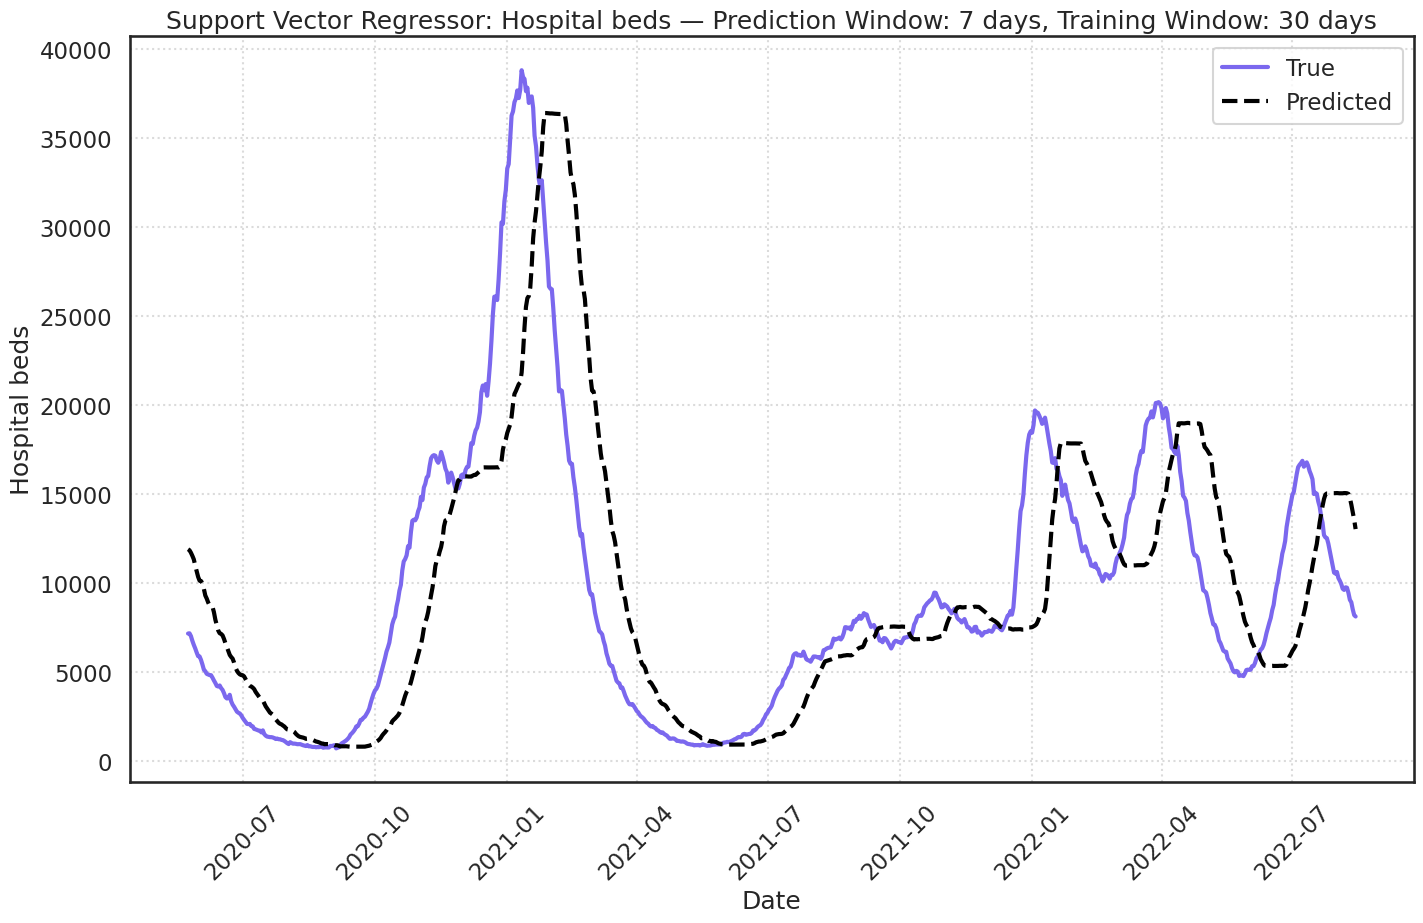

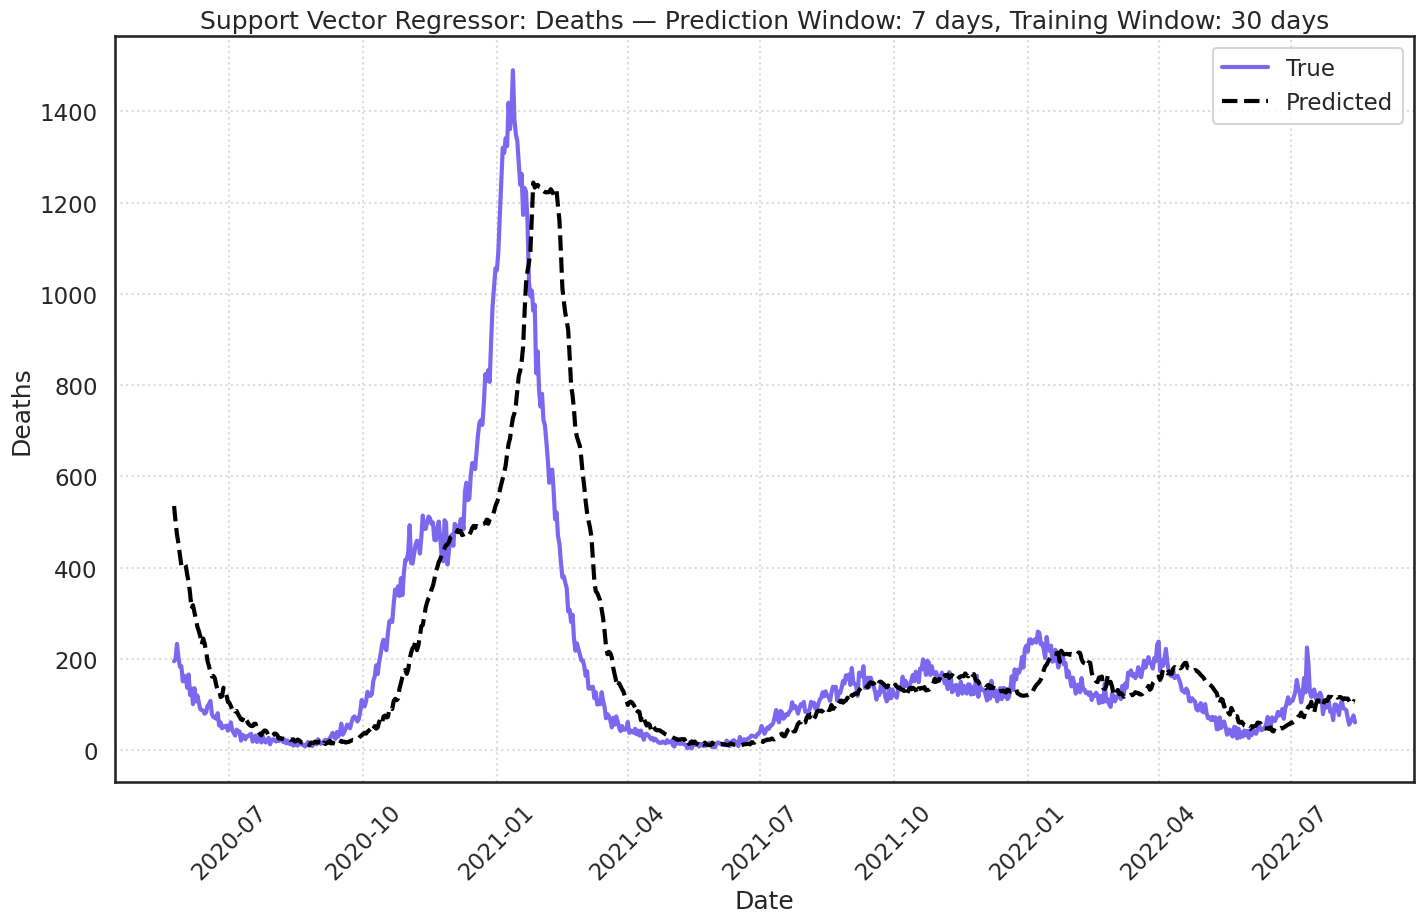

Processed 100/850 rows...
Processed 200/850 rows...
Processed 300/850 rows...
Processed 400/850 rows...
Processed 500/850 rows...
Processed 600/850 rows...
Processed 700/850 rows...
Processed 800/850 rows...


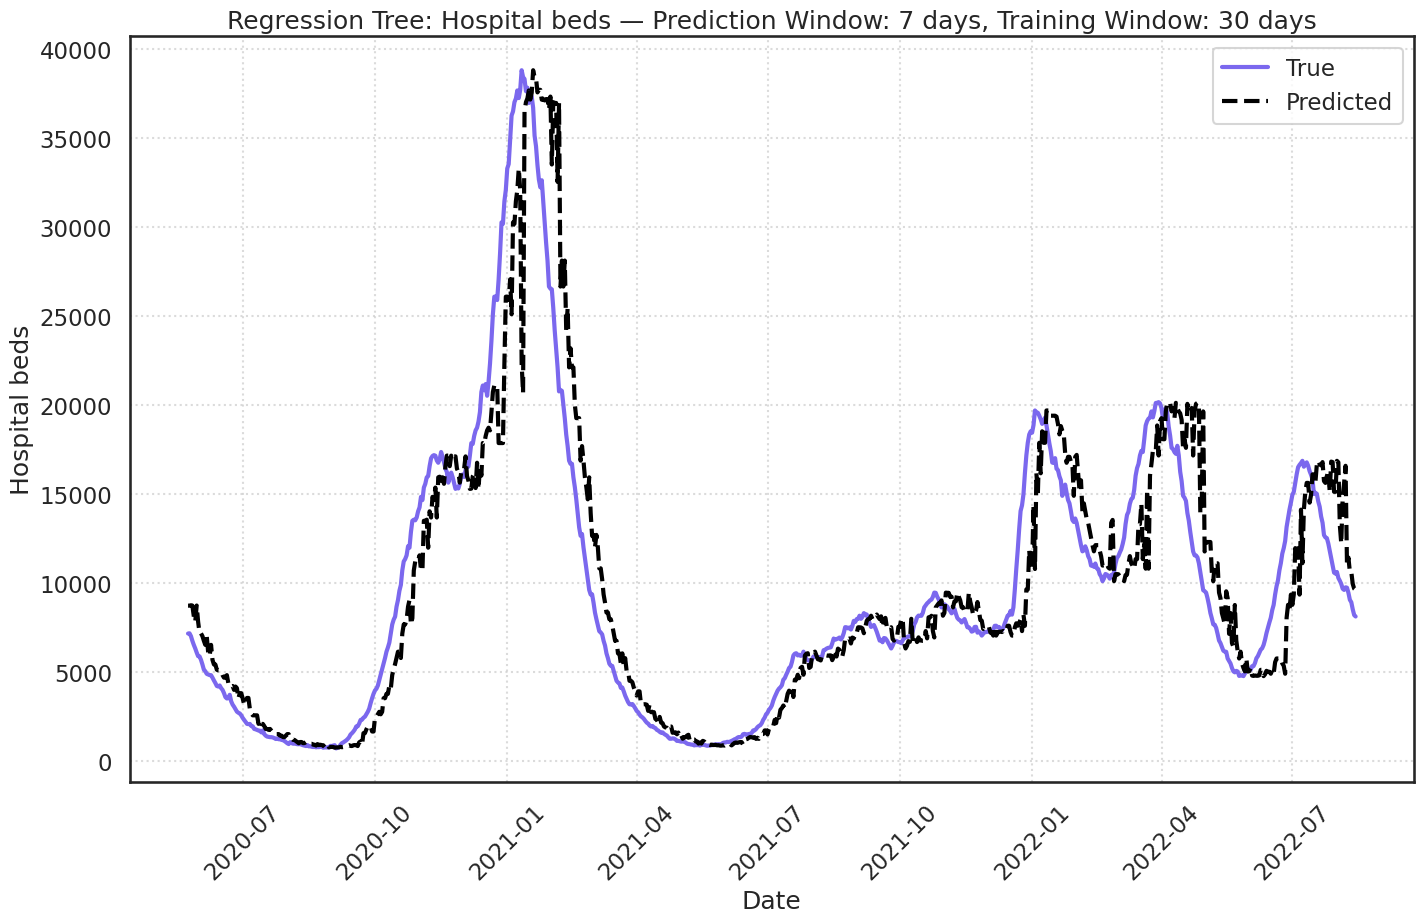

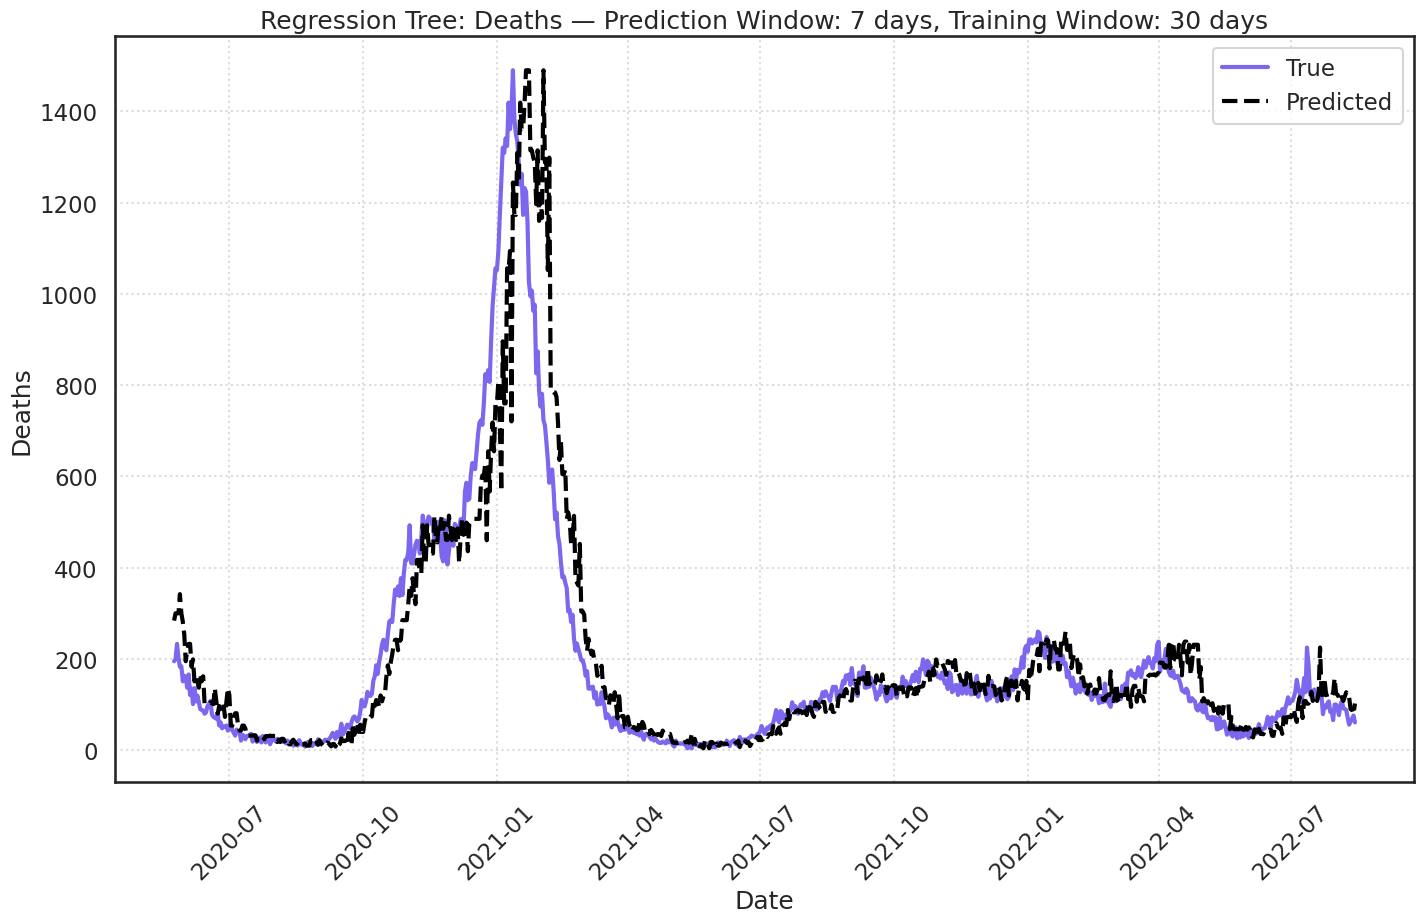

Processed 100/850 rows...
Processed 200/850 rows...
Processed 300/850 rows...
Processed 400/850 rows...
Processed 500/850 rows...
Processed 600/850 rows...
Processed 700/850 rows...
Processed 800/850 rows...


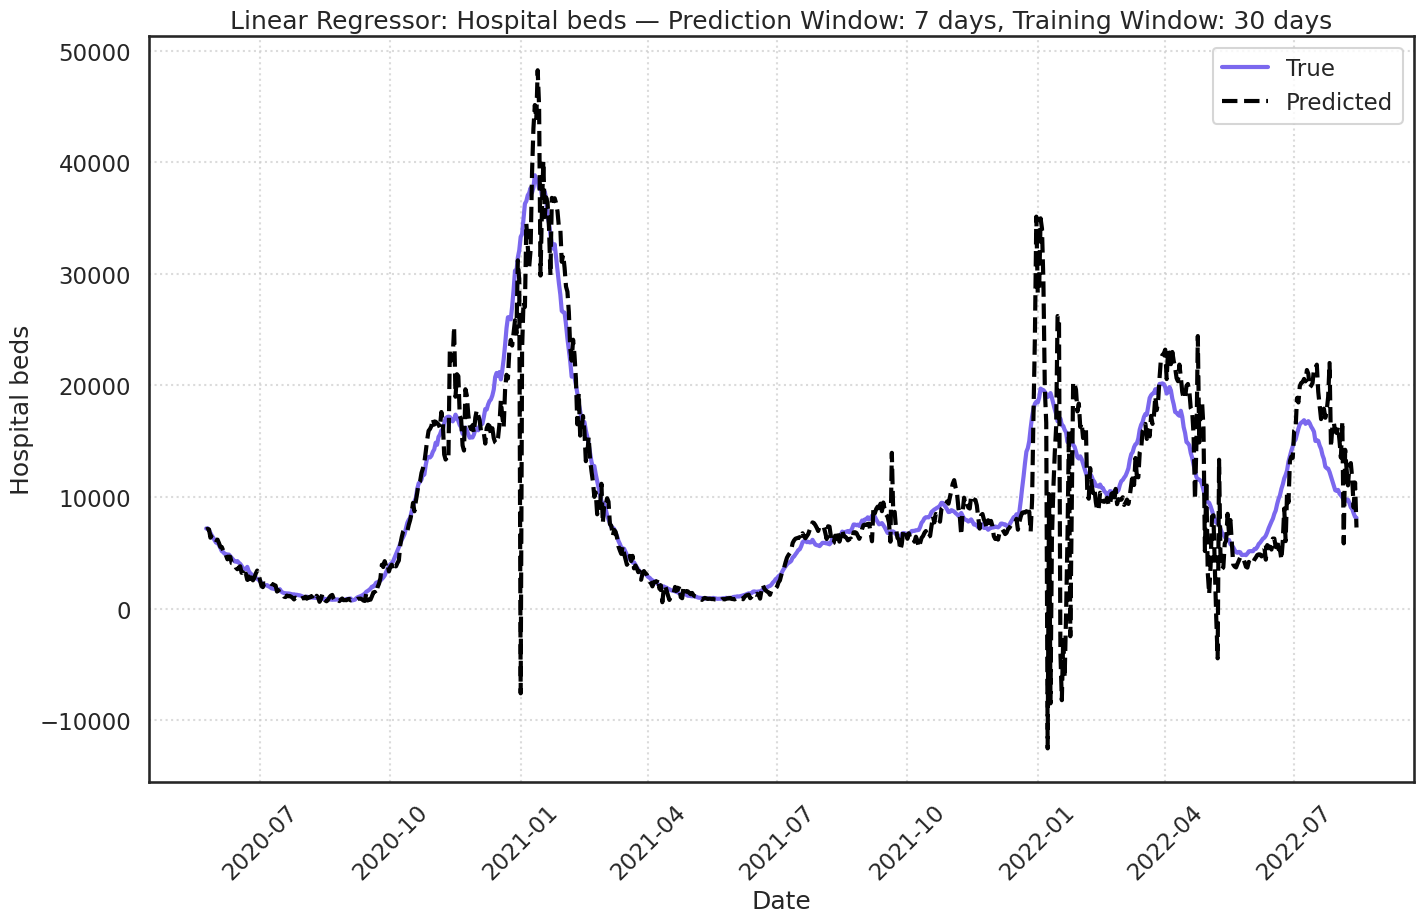

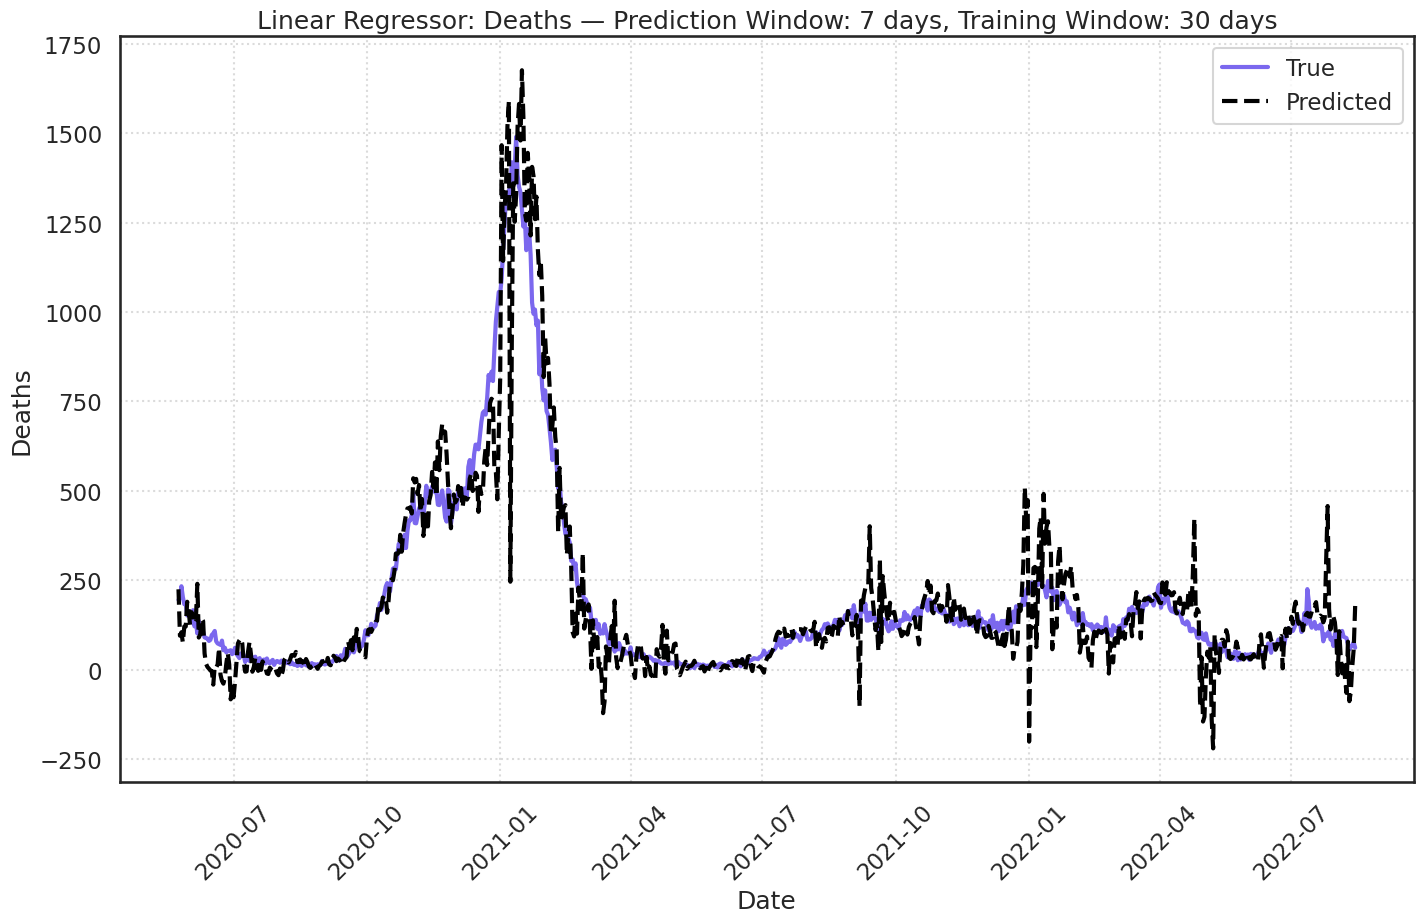

SVR Metrics:


""



Decision Tree Metrics:


""



Linear Regression Metrics:


""



All Metrics:


,Model,Target,Training Window,Prediction Window,MAE,RMSE,R2
0,Support Vector Regressor,Hospital beds,30,7,3980.552631,5619.704656,0.499836
1,Support Vector Regressor,Deaths,30,7,92.035913,173.655125,0.534194
2,Regression Tree,Hospital beds,30,7,2130.186221,3220.513033,0.835739
3,Regression Tree,Deaths,30,7,54.567862,107.368883,0.821932
4,Linear Regressor,Hospital beds,30,7,2011.843741,3919.713884,0.756671
...,...,...,...,...,...,...,...
67,Support Vector Regressor,Deaths,90,28,184.120822,297.188612,-0.273536
68,Regression Tree,Hospital beds,90,28,7672.408967,11127.273654,-0.997203
69,Regression Tree,Deaths,90,28,197.460160,361.914922,-0.888686
70,Linear Regressor,Hospital beds,90,28,8792.446946,12676.547345,-1.592070


In [ ]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

# Model 1: SVR
svr_model = SVR(kernel='rbf', C=10, epsilon=0.1)
svr_results, svr_metrics = rolling_forecast_model(
    svr_model, second_df, target_cols, scale=True, title_name="Support Vector Regressor",
    model_name=f"SVR_training_{window}_prediction_{target_delay}"
)

# Model 2: Decision Tree
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_results, tree_metrics = rolling_forecast_model(
    tree_model, second_df, target_cols, scale=False, title_name="Regression Tree",  # no scaling needed for trees
    model_name=f"DT_training_{window}_prediction_{target_delay}"
)

# Model 3: Simple Linear Regression
linreg_model = LinearRegression()
linreg_results, linreg_metrics = rolling_forecast_model(
    linreg_model, second_df, target_cols, scale=False, title_name="Linear Regressor",
    model_name=f"LR_training_{window}_prediction_{target_delay}"
)

print("SVR Metrics:")
display(svr_metrics)

print("\nDecision Tree Metrics:")
display(tree_metrics)

print("\nLinear Regression Metrics:")
display(linreg_metrics)

all_metrics = pd.concat([all_metrics, svr_metrics, tree_metrics, linreg_metrics], ignore_index=True)
print("\nAll Metrics:")
display(all_metrics)

After I ran all the combinations of training and prediction windows, I saved the combined metrics dataframe to a csv.

In [187]:
# print(all_metrics)

all_metrics.to_csv("all_metrics.csv", index=False)


To find the best models by different columns, I used the below code and added a colmumn to 'all_metrics.groupby'.

In [ ]:
# Get the best model by highest R2 for each Target
best_models = all_metrics.loc[all_metrics.groupby(['Target'])['R2'].idxmax()]

print(best_models)

               Model         Target  Training Window  Prediction Window  \
29  Linear Regressor         Deaths               60                  7   
52  Linear Regressor  Hospital beds               90                  7   

            MAE         RMSE        R2  
29    46.813726    90.642804  0.877346  
52  1783.867444  3019.826229  0.859244  


# Model Performance Analysis

Based on the performance metrics, the following conclusions can be regarding the best models, training windows, and prediction windows.

---

### 1. Best Model Overall by Target

- **Deaths:** Linear Regressor with a **60-day training window** and **7-day prediction window** is the top performer (R² = 0.877, MAE = 46.814, RMSE = 90.643).  
- **Hospital beds:** Linear Regressor with a **90-day training window** and **7-day prediction window** performs best (R² = 0.859, MAE = 1783.867, RMSE = 3019.826).  

**Conclusion:** Linear Regression consistently outperforms other models in terms of R² for both targets.

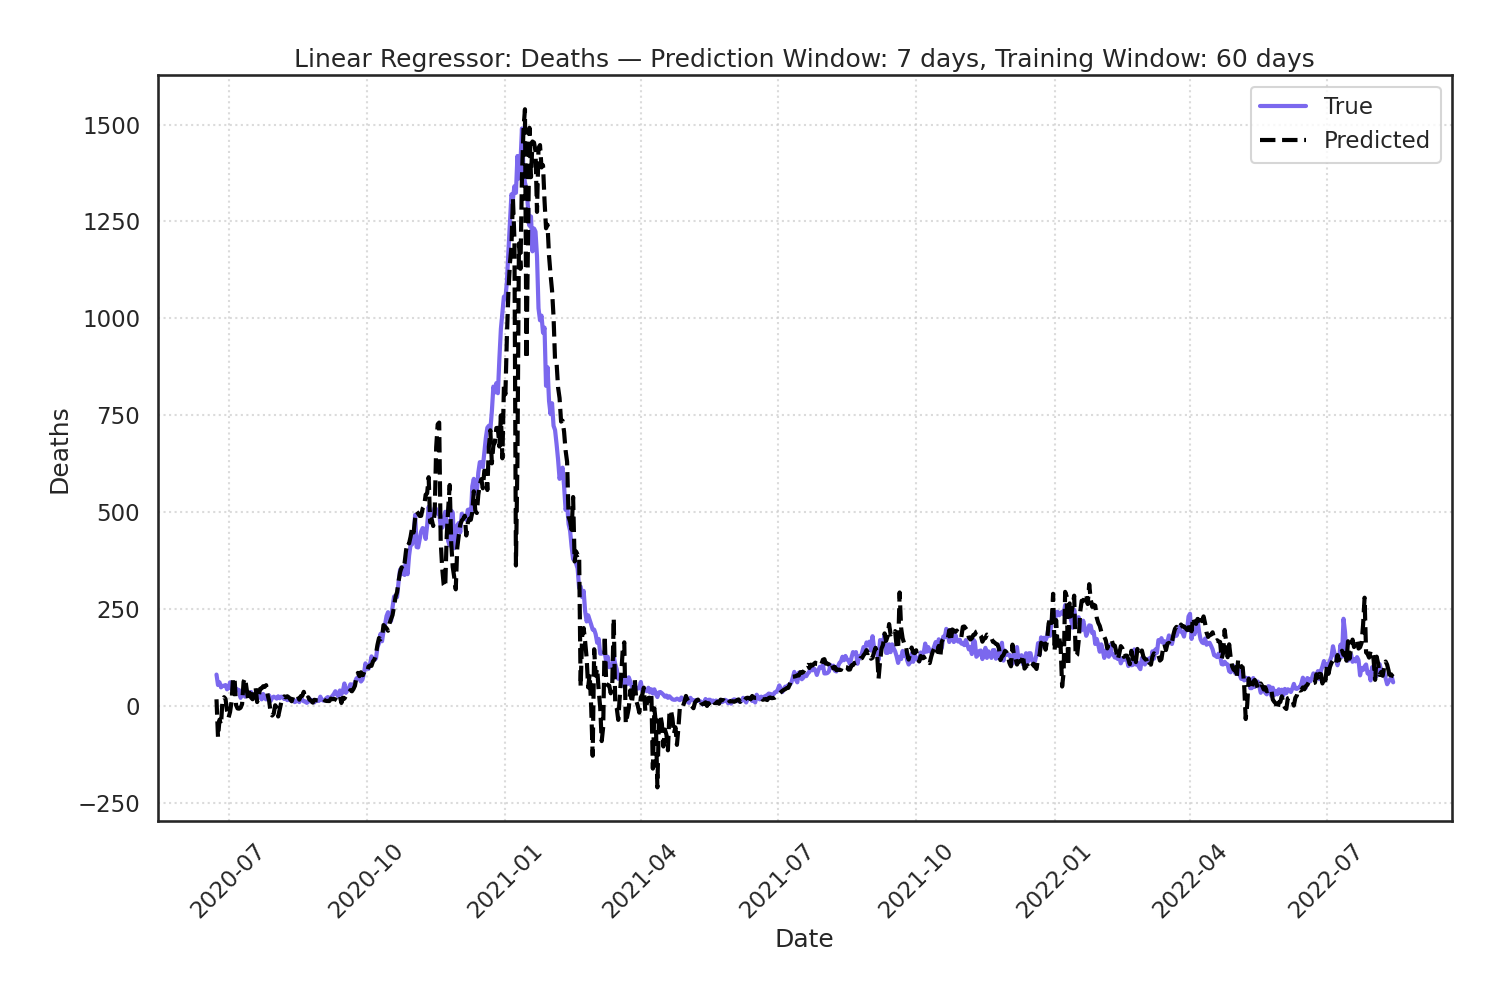

![LR_training_90_prediction_7_Hospital beds.png](<attachment:LR_training_90_prediction_7_Hospital beds.png>)

However, it is still evident from these plots that the prediction is far from perfect.

While the model captures the overall trend and timing of major peaks and troughs, it struggles with:
- **Amplitude errors**, particularly underestimating or overestimating the height of peaks during large surges.  
- **Short-term fluctuations**, where the model smooths out rapid changes due to the linear assumption.  
- **Phase shifts**, where predicted peaks or declines may occur slightly earlier or later than observed values.  

These discrepancies suggest that while mobility-based linear regression provides valuable predictive power for broader patterns, it may not fully capture the complex, nonlinear dynamics of real-world disease transmission and hospital demand.


### 2. Effect of Prediction Window

- **Deaths:** As the prediction window increases from 7 to 14 to 21 to 28 days:
  - R² drops from 0.877 to 0.583 to 0.419 to -0.080  
  - Errors (MAE, RMSE) increase
- **Hospital beds:** Longer prediction windows (14–28 days) lead to poor performance (R² between 0.518 and -0.039).  
- **Conclusion:** Short-term predictions (7 days) are much more reliable than long-term predictions.

### 3. Effect of Training Window

- **Deaths:** R² values are fairly high across different training windows (30 to 60 to 90 days: 0.859 to 0.877 to 0.814). The difference is small (~0.02–0.06), suggesting that performance is relatively consistent across different training window lengths.  
- **Hospital beds:** Similarly, R² values change modestly with training window (30 to 60 to 90 days: 0.836 to 0.855 to 0.859). Longer windows improve performance slightly, but short- and medium-length windows already give strong results.  

**Conclusion:**  
- For **short-term predictions**, the training window length is less critical than the choice of model or prediction window.  
- Moderate windows (30–60 days) are sufficient to achieve high R², making it possible to reduce computation and update models more frequently if needed.

### 4. Effect of Model Choice

- **Linear Regressor:** Strongest overall, especially for short-term predictions.  
- **Regression Tree:** Competitive for some cases but generally worse.  
- **Support Vector Regressor:** Consistently underperforms.  

**Conclusion:** Linear models are more effective than non-linear ones for these targets.

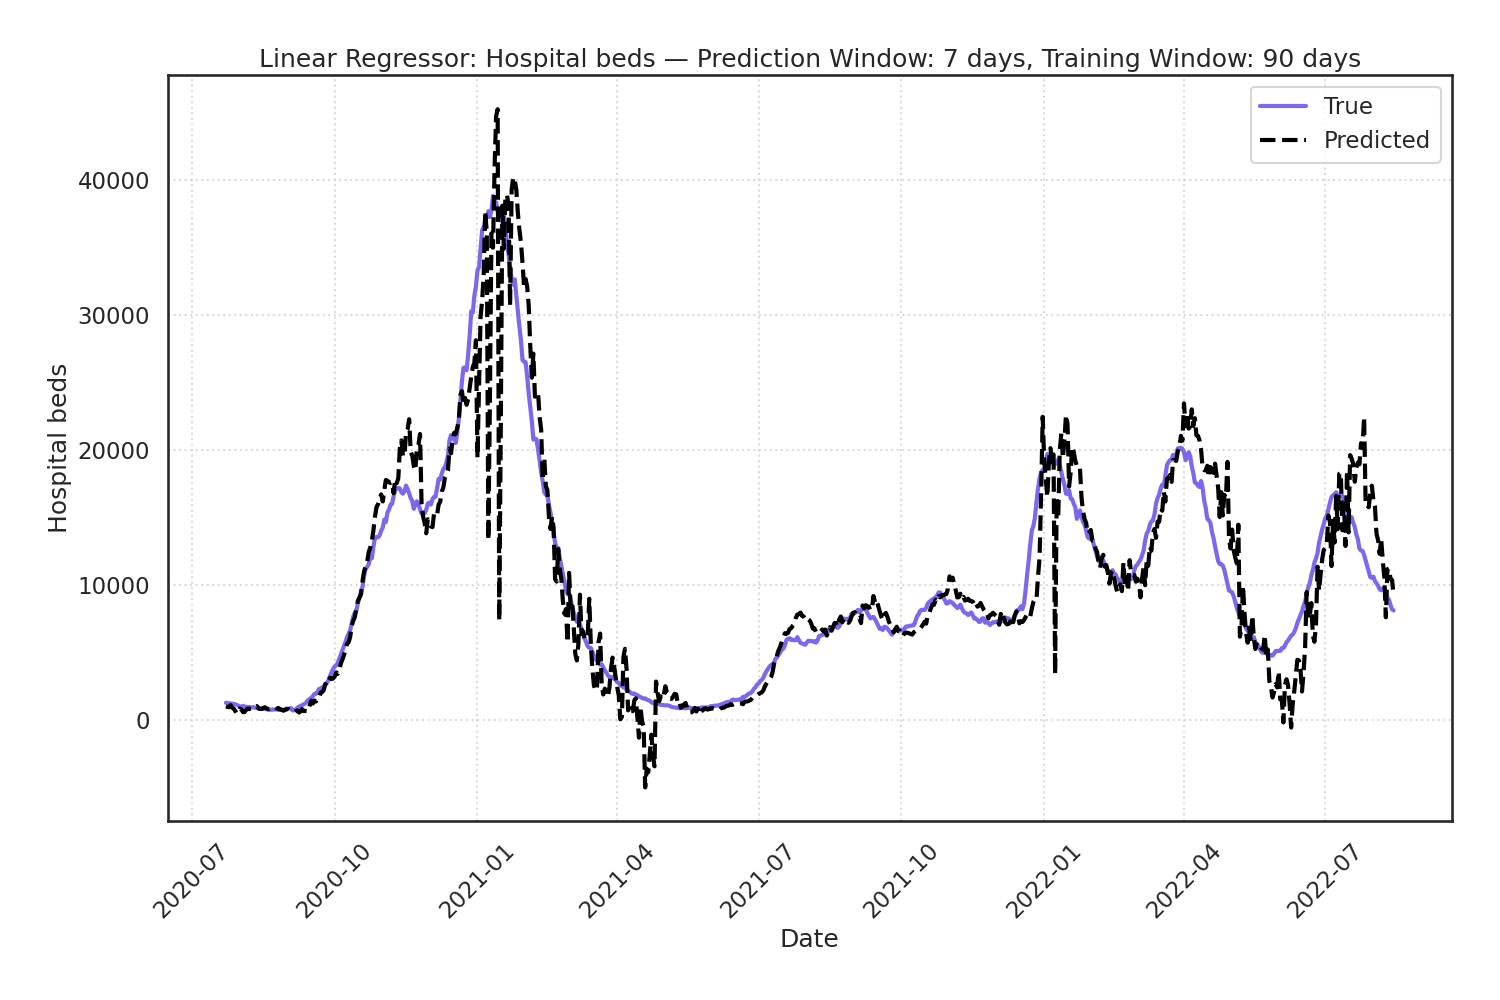

## Best Model by Target (Highest R²)

| Target         | Model            | Training Window | Prediction Window | MAE       | RMSE      | R²       |
|----------------|-----------------|----------------|-----------------|-----------|-----------|----------|
| Deaths         | Linear Regressor | 60             | 7               | 46.814    | 90.643    | 0.877    |
| Hospital beds  | Linear Regressor | 90             | 7               | 1783.867  | 3019.826  | 0.859    |

## Best Models by Target and Prediction Window

| Model             | Target         | Training Window | Prediction Window | MAE         | RMSE        | R²        |
|------------------|----------------|----------------|-----------------|------------|------------|-----------|
| Linear Regressor  | Deaths         | 60             | 7               | 46.814     | 90.643     | 0.877     |
| Linear Regressor  | Deaths         | 90             | 14              | 90.012     | 169.459    | 0.583     |
| Linear Regressor  | Deaths         | 90             | 21              | 123.166    | 200.418    | 0.419     |
| Regression Tree   | Deaths         | 30             | 28              | 137.122    | 267.889    | -0.080    |
| Linear Regressor  | Hospital beds  | 90             | 7               | 1783.867   | 3019.826   | 0.859     |
| Regression Tree   | Hospital beds  | 30             | 14              | 3785.055   | 5532.223   | 0.518     |
| Regression Tree   | Hospital beds  | 30             | 21              | 5035.557   | 7208.747   | 0.183     |
| Regression Tree   | Hospital beds  | 30             | 28              | 5690.886   | 8120.125   | -0.039    |

## Best Models by Target and Training Window

| Model             | Target         | Training Window | Prediction Window | MAE       | RMSE      | R²       |
|------------------|----------------|----------------|-----------------|-----------|-----------|----------|
| Linear Regressor  | Deaths         | 30             | 7               | 53.981    | 95.560    | 0.859    |
| Linear Regressor  | Deaths         | 60             | 7               | 46.814    | 90.643    | 0.877    |
| Regression Tree   | Deaths         | 90             | 7               | 57.918    | 112.897   | 0.814    |
| Regression Tree   | Hospital beds  | 30             | 7               | 2130.186  | 3220.513  | 0.836    |
| Linear Regressor  | Hospital beds  | 60             | 7               | 1813.548  | 3062.437  | 0.855    |
| Linear Regressor  | Hospital beds  | 90             | 7               | 1783.867  | 3019.826  | 0.859    |

## Best Models by Target and Model

| Model                  | Target         | Training Window | MAE       | RMSE      | R²       |
|------------------------|----------------|----------------|-----------|-----------|----------|
| Linear Regressor        | Deaths         | 60             | 46.814    | 90.643    | 0.877    |
| Regression Tree         | Deaths         | 30             | 54.568    | 107.369   | 0.822    |
| Support Vector Regressor| Deaths         | 30             | 92.036    | 173.655   | 0.534    |
| Linear Regressor        | Hospital beds  | 90             | 1783.867  | 3019.826  | 0.859    |
| Regression Tree         | Hospital beds  | 30             | 2130.186  | 3220.513  | 0.836    |
| Support Vector Regressor| Hospital beds  | 30             | 3980.553  | 5619.705  | 0.500    |

### Discussion

Across both targets, the **Linear Regressor** consistently achieved the highest R² and lowest error metrics, indicating the best overall performance.  
It effectively captures the general trends between mobility features and health outcomes, suggesting that these relationships are mostly linear at the chosen time scales.

The **Regression Tree** models performed moderately well, with slightly lower R² values. This indicates that while they can model some nonlinear relationships, they may overfit smaller fluctuations and lose generalization power.

The **Support Vector Regressor** performed the worst among the three. Its relatively low R² and higher MAE/RMSE suggest it struggled to generalize, possibly due to too much data.

Overall, these results suggest that for this dataset:
- **Linear models** are sufficiently accurate and generalize best.  
- **Tree-based models** can still be competitive but may require more careful tuning.  
- **SVR** may not be suitable for this type of temporal data without more feature engineering or kernel adjustments.

## Acknowledgements
I used GPT-5 to generate some of the code - it is usually mentioned in the Markdown section above the specific code. I also used it to rephrase some of my Markdown comments for better comprehension. It particularly helped with formatting in Markdown as well, such as for the metrics tables above.